In [29]:
import pandas as pd

import xgboost as xgb  # mention ta to download this
import constants as cs
import numpy as np
import matplotlib.pyplot as plt
import zipfile
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, make_scorer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor
from sklearn.neural_network import MLPRegressor
import joblib
import pickle

In [52]:
# import sklearn # to check the version
# print(sklearn.__version__)
# print(xgb.__version__)

1.0.2
1.7.6


In [30]:
def load_data(filename: str) -> pd.DataFrame:
    with zipfile.ZipFile(f"../{filename}.zip") as data_zip:
        with data_zip.open(f"{filename}.csv") as developer_data:
            return pd.read_csv(developer_data)

In [31]:
na_data = load_data(cs.NA_TRAIN_DATA)

compensation = na_data[cs.COMPENSATION]
X_data = na_data.drop(columns=[cs.COMPENSATION])

print(X_data.columns)
# Create columns for job title and organisation size
X_data = pd.get_dummies(X_data)
print(X_data.columns)
print(X_data.shape)

X_train, X_valid, y_train, y_valid = train_test_split(X_data, compensation)

Index(['Age', 'EdLevel', 'YearsCode', 'YearsCodePro', 'DevType', 'OrgSize',
       'Country', 'Industry', 'JavaScript', 'SQL', 'HTML/CSS', 'Python',
       'TypeScript', 'PostgreSQL', 'MySQL', 'Microsoft SQL Server', 'SQLite',
       'Redis', 'Docker', 'npm', 'Homebrew', 'Pip', 'Webpack', 'React',
       'Node.js', 'jQuery', 'ASP.NET CORE', 'Angular',
       'Amazon Web Services (AWS)', 'Microsoft Azure', 'Google Cloud',
       'Cloudflare', 'Digital Ocean', '.NET (5+) ',
       '.NET Framework (1.0 - 4.8)', 'Pandas', 'NumPy', 'Apache Kafka'],
      dtype='object')
Index(['Age', 'EdLevel', 'YearsCode', 'YearsCodePro', 'Country', 'Industry',
       'JavaScript', 'SQL', 'HTML/CSS', 'Python', 'TypeScript', 'PostgreSQL',
       'MySQL', 'Microsoft SQL Server', 'SQLite', 'Redis', 'Docker', 'npm',
       'Homebrew', 'Pip', 'Webpack', 'React', 'Node.js', 'jQuery',
       'ASP.NET CORE', 'Angular', 'Amazon Web Services (AWS)',
       'Microsoft Azure', 'Google Cloud', 'Cloudflare', 'Digital Oc

In [32]:
 # Feature scaling for models that need scaled data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

In [33]:
scaler_model_filename = f'{cs.ML_MODELS_FOLDER}/scaler.pkl'
joblib.dump(scaler, scaler_model_filename)

['./ml_models/scaler.pkl']

In [34]:
def custom_accuracy_score(y_true, y_pred):
        accuracy_count = 0
        for true_val, pred_val in zip(y_true, y_pred):
            if abs(true_val - pred_val) <= 15000:
                accuracy_count += 1

        accuracy = accuracy_count / len(y_true)
        return accuracy

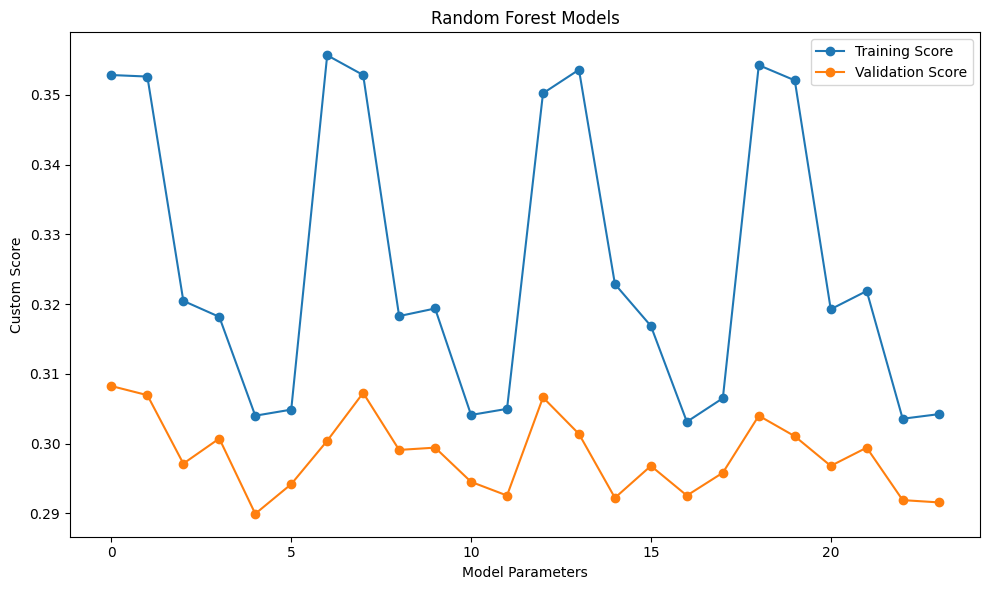

In [35]:
# Defining the parameter grid
rf_param_grid = {
    'n_estimators': [150, 200],
    'max_depth': [75, 100, 125, 150],
    'min_samples_leaf': [10, 20, 30]
}
# Create an empty list to store the results of each model and also the best model so it can be resused
results = []
rf_models = []

# Iterate through the parameter grid and perform GridSearchCV for each combination
for params in ParameterGrid(rf_param_grid):
    # Create and fit the model
    rf_model = RandomForestRegressor(**params)
    rf_model.fit(X_train, y_train)
    rf_models.append(rf_model)

    rf_custom_score_train = custom_accuracy_score(y_train, rf_model.predict(X_train))
    rf_custom_score_valid = custom_accuracy_score(y_valid, rf_model.predict(X_valid))

    # Append the results to the list
    results.append({
        'params': params,
        cs.TRAINING_SCORE: rf_custom_score_train,
        cs.VALIDATION_SCORE: rf_custom_score_valid
    })

# Plot the results on a graph
train_scores = [result[cs.TRAINING_SCORE] for result in results]
valid_scores = [result[cs.VALIDATION_SCORE] for result in results]

plt.figure(figsize=(10, 6))
plt.plot(range(len(results)), train_scores, label='Training Score', marker='o')
plt.plot(range(len(results)), valid_scores, label='Validation Score', marker='o')
# plt.xticks(range(len(results)), [str(result['params']) for result in results], rotation=45)
plt.title('Random Forest Models')
plt.xlabel('Model Parameters')
plt.ylabel('Custom Score')
plt.legend()
plt.tight_layout()
plt.savefig(f"{cs.ML_MODELS_FOLDER}/{cs.RANDOM_FOREST_MODELS}.png")

In [50]:
best_rf_model = rf_models[12] 
print(results[12])
print(results[8])
# max depth 125 min sample leaf 10 n estimators 150
best_rf_model_filename = f'{cs.ML_MODELS_FOLDER}/{cs.BEST_RF_MODELS}.pkl'
joblib.dump(best_rf_model, best_rf_model_filename)

{'params': {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}, 'train_score': 0.31642670157068065, 'valid_score': 0.3125}
{'params': {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 300}, 'train_score': 0.4731675392670157, 'valid_score': 0.34522251308900526}


['./ml_models/best_rf_models.pkl']

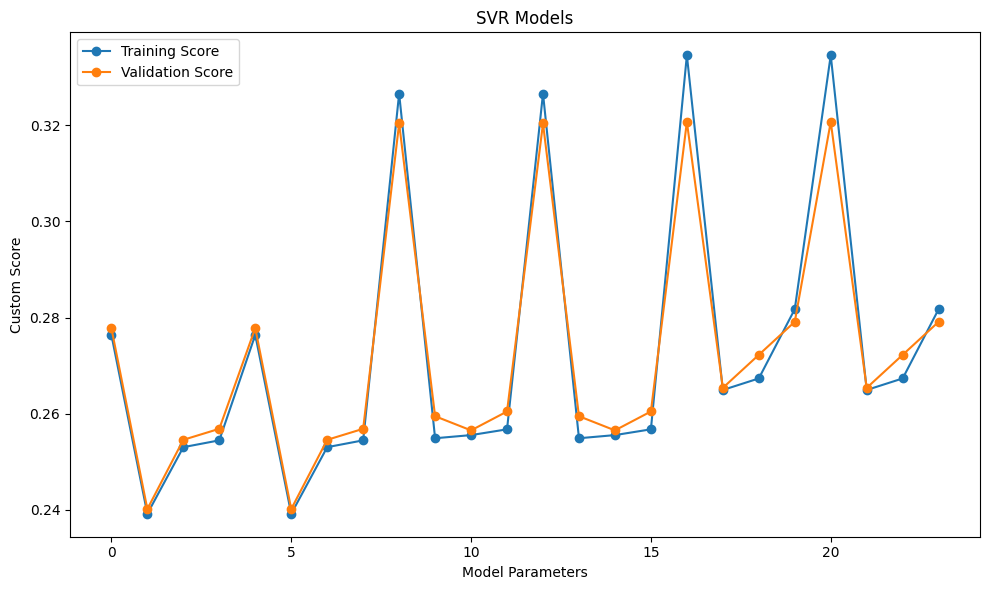

In [39]:
# Training with an svr model 
results = []
svr_models = []

svr_param_grid = {
        'C': [1, 10, 100],
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'gamma': ['scale', 'auto']
    }

for params in ParameterGrid(svr_param_grid):
    # Set the parameters for the RandomForestRegressor in the pipeline
    svr_model = SVR(**params)
    svr_model.fit(X_train_scaled, y_train)
    svr_models.append(svr_model)

    # Calculate custom scoring for training and validation data
    svr_custom_score_train = custom_accuracy_score(y_train, svr_model.predict(X_train_scaled))
    svr_custom_score_valid = custom_accuracy_score(y_valid, svr_model.predict(X_valid_scaled))

    # Append the results to the list
    results.append({
        'params': params,
        cs.TRAINING_SCORE: svr_custom_score_train,
        cs.VALIDATION_SCORE: svr_custom_score_valid
    })

# Plot the results on a graph
train_scores = [result[cs.TRAINING_SCORE] for result in results]
valid_scores = [result[cs.VALIDATION_SCORE] for result in results]

plt.figure(figsize=(10, 6))
plt.plot(range(len(results)), train_scores, label='Training Score', marker='o')
plt.plot(range(len(results)), valid_scores, label='Validation Score', marker='o')
# plt.xticks(range(len(results)), [str(result['params']) for result in results], rotation=45)
plt.title('SVR Models')
plt.xlabel('Model Parameters')
plt.ylabel('Custom Score')
plt.legend()
plt.tight_layout()
plt.savefig(f"{cs.ML_MODELS_FOLDER}/{cs.SVR_MODELS}.png")

In [40]:
best_svr_model = svr_models[20]
print(results[20])
# C 100 ,gamma auto, kernel linear
best_svr_model_filename = f'{cs.ML_MODELS_FOLDER}/{cs.BEST_SVR_MODELS}.pkl'
joblib.dump(best_svr_model, best_svr_model_filename)

{'params': {'C': 100, 'gamma': 'auto', 'kernel': 'linear'}, 'train_score': 0.3345331588132635, 'valid_score': 0.3206806282722513}


['./ml_models/best_svr_models.pkl']

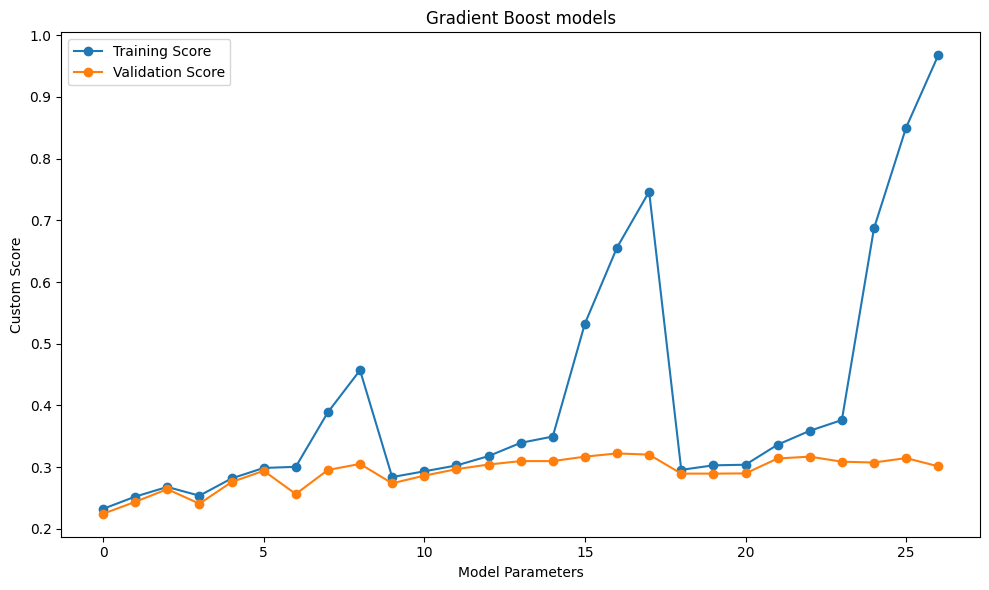

In [42]:
results = []
gb_models = []
gb_param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 10]
    }
for params in ParameterGrid(gb_param_grid):
    gb_model = GradientBoostingRegressor(**params)
    gb_model.fit(X_train, y_train)
    gb_models.append(gb_model)

    # Calculate custom scoring for training and validation data
    gb_custom_score_train = custom_accuracy_score(y_train, gb_model.predict(X_train))
    gb_custom_score_valid = custom_accuracy_score(y_valid, gb_model.predict(X_valid))

    # Append the results to the list
    results.append({
        'params': params,
        cs.TRAINING_SCORE: gb_custom_score_train,
        cs.VALIDATION_SCORE: gb_custom_score_valid
    })

# Plot the results on a graph
train_scores = [result[cs.TRAINING_SCORE] for result in results]
valid_scores = [result[cs.VALIDATION_SCORE] for result in results]

plt.figure(figsize=(10, 6))
plt.plot(range(len(results)), train_scores, label='Training Score', marker='o')
plt.plot(range(len(results)), valid_scores, label='Validation Score', marker='o')
# plt.xticks(range(len(results)), [str(result['params']) for result in results], rotation=45)
plt.title('Gradient Boost models')
plt.xlabel('Model Parameters')
plt.ylabel('Custom Score')
plt.legend()
plt.tight_layout()
plt.savefig(f"{cs.ML_MODELS_FOLDER}/{cs.GB_MODELS}.png")

In [43]:
best_gb_model = gb_models[12]
print(results[12])
# same as xg boost
best_gb_model_filename = f'{cs.ML_MODELS_FOLDER}/{cs.BEST_GB_MODELS}.pkl'
joblib.dump(best_gb_model, best_gb_model_filename)

{'params': {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}, 'train_score': 0.31795375218150085, 'valid_score': 0.3043193717277487}


['./ml_models/best_gb_models.pkl']

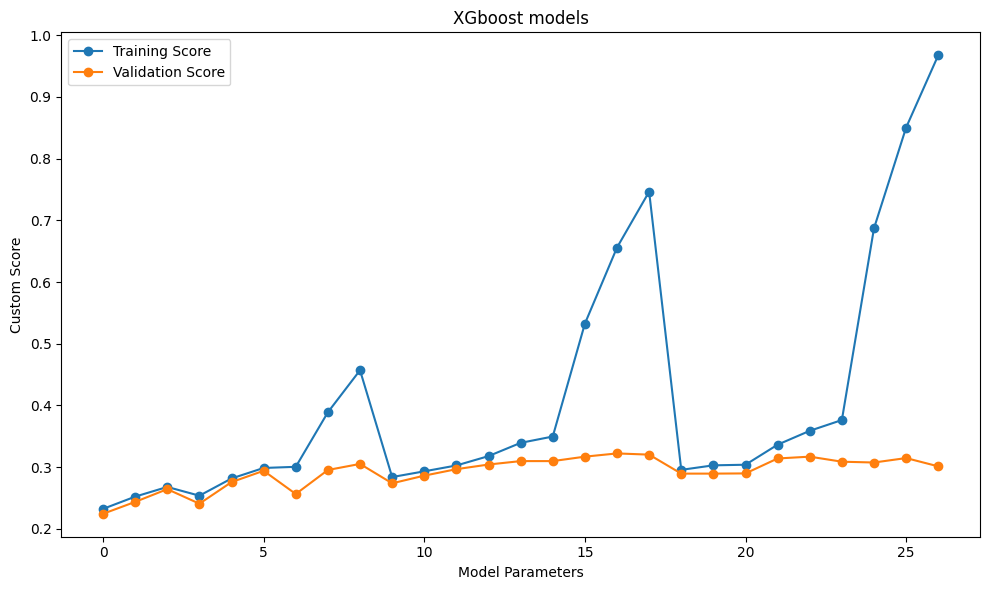

In [44]:
results = []
xgb_models = []

xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 10]
}

for params in ParameterGrid(xgb_param_grid):
    xgb_model = xgb.XGBRegressor(**params)
    xgb_model.fit(X_train, y_train)
    xgb_models.append(xgb_model)

    # Calculate custom scoring for training and validation data
    xgb_custom_score_train = custom_accuracy_score(y_train, xgb_model.predict(X_train))
    xgb_custom_score_valid = custom_accuracy_score(y_valid, xgb_model.predict(X_valid))

    # Append the results to the list
    results.append({
        'params': params,
        cs.TRAINING_SCORE: xgb_custom_score_train,
        cs.VALIDATION_SCORE: xgb_custom_score_valid
    })
plt.figure(figsize=(10, 6))
plt.plot(range(len(results)), train_scores, label='Training Score', marker='o')
plt.plot(range(len(results)), valid_scores, label='Validation Score', marker='o')
# plt.xticks(range(len(results)), [str(result['params']) for result in results], rotation=45)
plt.title('XGboost models')
plt.xlabel('Model Parameters')
plt.ylabel('Custom Score')
plt.legend()
plt.tight_layout()
plt.savefig(F"{cs.ML_MODELS_FOLDER}/{cs.XGBOOST_MODELS}.png")

In [45]:
best_xgboost_model = xgb_models[12]
print(results[12])
#paraemters larning rate 0.05, max depth 5, n estimators 100
best_xgboost_model_filename = f'{cs.ML_MODELS_FOLDER}/{cs.BEST_XGBOOST_MODELS}.pkl'
joblib.dump(best_xgboost_model, best_xgboost_model_filename)

{'params': {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}, 'train_score': 0.31642670157068065, 'valid_score': 0.3125}


['./ml_models/best_xgboost_models.pkl']

In [46]:
import os
X_valid.to_csv(f"X_valid_data.csv", index=False)
with zipfile.ZipFile(f"../X_valid_data.zip", 'w') as zipf:
    zipf.write(f"X_valid_data.csv")
os.remove(f"X_valid_data.csv")
y_valid.to_csv(f"y_valid_data.csv", index=False)

with zipfile.ZipFile(f"../y_valid_data.zip", 'w') as zipf:
    zipf.write(f"y_valid_data.csv")
os.remove(f"y_valid_data.csv")

In [48]:
X_valid.to_csv(f"X_train_data.csv", index=False)
with zipfile.ZipFile(f"../X_train_data.zip", 'w') as zipf:
    zipf.write(f"X_train_data.csv")
os.remove(f"X_train_data.csv")
y_valid.to_csv(f"y_train_data.csv", index=False)
with zipfile.ZipFile(f"../y_train_data.zip", 'w') as zipf:
    zipf.write(f"y_train_data.csv")
os.remove(f"y_train_data.csv")